In [20]:
#   export
# %matplotlib inline
#   interactive
%matplotlib notebook  
#%pylab
import numpy as np
import matplotlib.pyplot as plt
from common import *
from cluster_gaia_query import COMBINED_TABLE_PATH, DIST_TABLE_PATH, GAIA_TABLE_PATH, main
import astropy.units as u
from astropy.coordinates import SkyCoord
import pandas as pd
from matplotlib.colors import LogNorm

import ipywidgets as widgets
from IPython.display import HTML
HTML('''
<style>
    .text_cell_render {
    font-size: 12pt;
    line-height: 135%;
    word-wrap: break-word;}
    
    .container { 
    min-width: 1300px;
    width:70% !important; 
    }}
</style>''')

In [2]:
# disable for interactive
#plt.rcParams['figure.figsize'] = (9, 6)
#plt.rcParams['figure.dpi'] = 150

# Context and introduction

## Astrometry
A planned science case of the ELT instrument MICADO is perform precise astrometry on globular clusters to improve constraints on the existence of intermediate mass black holes within the clusters.
As ELT time is going to be expensive, it would increase the efficiency of the instrument if no separate calibration images had to be taken for a science exposure. 

One key item to calibrate is the geometric distortion of the images. The extent and predictability (Riechert?)[2] 
is not fully understood yet, but it is assumed that only few reference sources within an image would allow adequate distortion calibration to perform relative astrometry(citation_needed).

This report estimates the amount and quality of available guide stars around objects of interest. The analysis is performed on the globular clusters from the catalogue used in [3]. As these object had enough associated GAIA-sources to estimate their proper motion, it is assumed that there will be enough reference sources available for follow-up observations with MICADO.

## Gaia

The GAIA mission currently provides the most expansive and high quality catalogue of astrometric sources. There is however no straightforward way to accertain the astrometric precision of a source from the main table of GAIA itself.

(Rybizki et al.) [1] Present a neural-net based classifier for the fidelity of the astrometric solution based on the input of the main GAIA table and auxiliary information made available at the German Astrophysical Virtual Observatory(GAVO).

The paper names $\mathrm{fidelity} > 0.5$ as a cutoff for good vs bad sources, but note that users of the model may have to adapt the cutoff according to their needs.

# Data aquision and preparation
[1] provide their classifier as a saved `keras` model at https://keeper.mpdl.mpg.de/d/21d3582c0df94e19921d/. The code needed to run the classifier was extracted from the provided notebook https://colab.research.google.com/drive/1lPzhGSSIjx2nQ7XM2v8bQZtkf0Atrk0z?usp=sharing and its correctness checked by running it against the training data.

The names of the clobular clusters among the candidate sources provided in [3] are extracted and used to perform a cone search with radius $60 \mathrm{as}$ around each object. This is performed on the main table of the GAIA preliminary data release 3. Additionally to the gaia columns, the information from the input catalogue, most importantly position and name of the target objects, are saved in the table.(`cluster_gaia_query.py::get_gaia_table_cluster`)

`common.py::read_or_query` provides a mechanism to cache the query-results as gziped pickle files. This was done instead of using the astropy Table IO functionality due to poor performance of the latter.

The information from the main GAIA table is merged with the columns available in `gedr3spurnew.main` available at 
http://dc.zah.uni-heidelberg.de/tap. (`common.py::get_dist_table`). 

Finally, the astrometric fidelity of each source is computed by applying the classifier to the data, saved in the joined table and saved to disk. (`cluster_gaia_query.py::main`)

An at the time of writing ephemerally available table `gedr3spur.main` containes the fidelity criterion as column `fidelity_v2` so future analyses can probably skip running the model locally and use the tabulated data if it's made available permanently.

To perform this analysis on a different catalogue of objects, one only needs to replace the reference from which `object_table` is read in `cluster_gaia_query.py::main` with the table from a custom SIMBAD query or provide a similar table with a `MAIN_ID` column resolvable by GAIA and columns `['RA_d', 'DEC_d' ,'GALDIM_MAJAXIS']` present.

In [3]:
# uncomment and run this to query and create tables
# combined_table = main() 

In [4]:
# read existing tables
gaia_table = read_table(GAIA_TABLE_PATH)
dist_table = read_table(DIST_TABLE_PATH)
combined_table = read_table(COMBINED_TABLE_PATH)

sample of the combined table:

In [5]:
combined_table['target_name_id','ra','dec', 'target_ra', 'target_dec', 'target_dist', 'target_coordinates']

target_name_id,ra,dec,target_ra,target_dec,target_dist,target_coordinates
,deg,deg,hourangle,deg,deg,"deg,deg"
str8,float64,float64,float64,float64,float64,object
M 13,250.42170929550826,36.44510085604912,16.69489833,36.46131900,0.016280210348203455,"250.42347500000005,36.461319"
M 13,250.4223346225773,36.44660597817976,16.69489833,36.46131900,0.014741585714534815,"250.42347500000005,36.461319"
M 13,250.42303104415697,36.44511566980642,16.69489833,36.46131900,0.0162072645557207,"250.42347500000005,36.461319"
M 13,250.42727151483183,36.44892602509164,16.69489833,36.46131900,0.012763637274772746,"250.42347500000005,36.461319"
M 13,250.4302820564804,36.448954985408456,16.69489833,36.46131900,0.013522027345361185,"250.42347500000005,36.461319"
M 13,250.43031611991435,36.45045526584703,16.69489833,36.46131900,0.012177736370141159,"250.42347500000005,36.461319"
...,...,...,...,...,...,...
M 72,313.36126642005667,-12.525095303454302,20.89102800,-12.53731000,0.012870076264425693,"313.36542,-12.53731"


# Analysis
## Cutoff for astrometric Precision
Plotting the histogram of the overall astrometric error of gaia sources reveals a long tail of source with errors over $20 \mathrm{mas}$. As more than 95% of sources have an error below $27 \mathrm{mas}$, $30\mathrm{mas}$ would be a very conservative cutoff. For evaluating the possibility of MICADO calibration, the positional error should not exceed the pixel scale of $4 \mathrm{mas}$. 

count    154823.000000
mean          5.156465
std          12.002469
min           0.009032
50%           0.991013
75%           3.505663
90%          13.435149
95%          27.647388
99%          64.710156
99.9%        97.028591
max         136.931351
dtype: float64

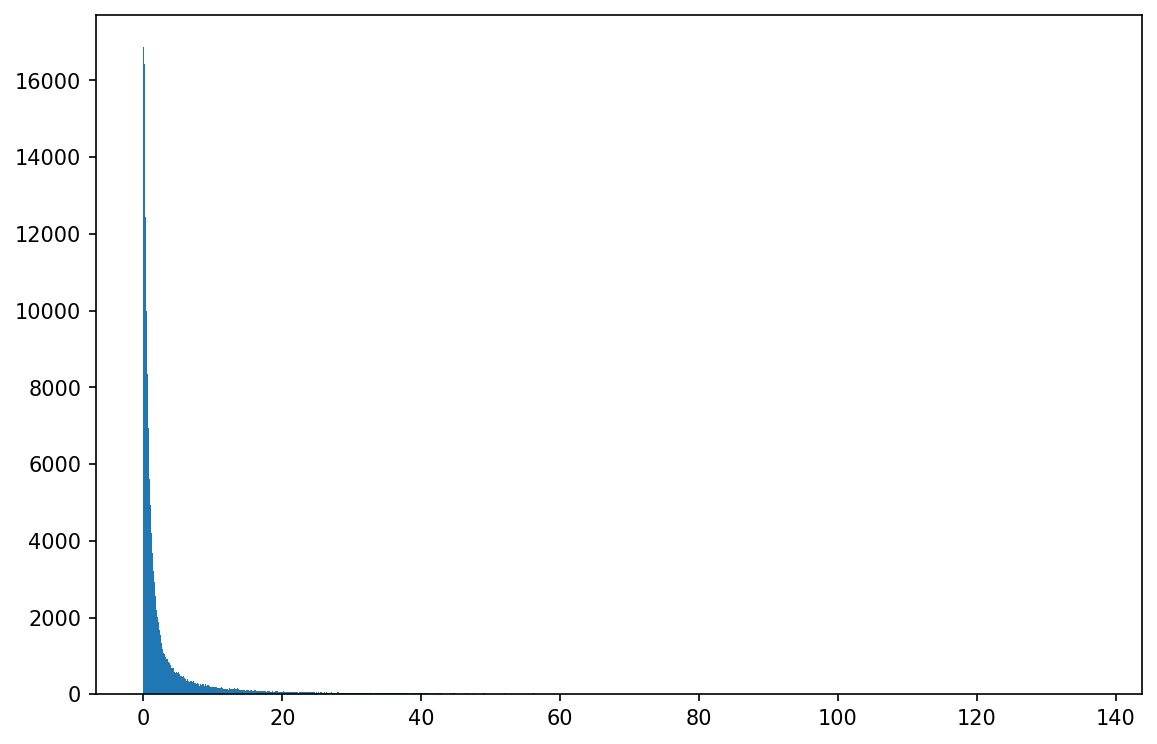

In [6]:
plt.figure()
error = np.sqrt(combined_table['ra_error']**2+combined_table['dec_error']**2)
combined_table['combined_error'] = error
plt.hist(error,bins=1000)
pd.Series(error).describe(percentiles=[.5,.75,.9,.95,.99,.999])


With the data assembled into a single table, it is relatively straightforward to filter this table for good sources for quality and distance to the observation target with a selector, e.g.:

In [7]:
selector = (combined_table['target_dist']<60*u.arcsec)&(combined_table['good']>0.5) & (error<(4*u.mas))
filtered_table = combined_table[selector]
filtered_table

target_name_id,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,dist,target_name_1,TYPED_ID,ANG_DIST,target_name_2,OTYPE_S,target_ra,target_dec,COO_ERR_MAJA_d,COO_ERR_MINA_d,COO_ERR_ANGLE_d,PMRA,PMDEC,PM_ERR_MAJA,PM_ERR_MINA,PM_ERR_ANGLE,PLX_VALUE,RV_VALUE,Z_VALUE,GALDIM_MAJAXIS,GALDIM_MINAXIS,GALDIM_ANGLE,SP_TYPE,MORPH_TYPE,NB_REF,FILTER_NAME_U,FLUX_U,FLUX_ERROR_U,FLUX_SYSTEM_U,FLUX_BIBCODE_U,FLUX_VAR_U,FLUX_MULT_U,FLUX_QUAL_U,FLUX_UNIT_U,FILTER_NAME_B,FLUX_B,FLUX_ERROR_B,FLUX_SYSTEM_B,FLUX_BIBCODE_B,FLUX_VAR_B,FLUX_MULT_B,FLUX_QUAL_B,FLUX_UNIT_B,FILTER_NAME_V,FLUX_V,FLUX_ERROR_V,FLUX_SYSTEM_V,FLUX_BIBCODE_V,FLUX_VAR_V,FLUX_MULT_V,FLUX_QUAL_V,FLUX_UNIT_V,FILTER_NAME_R,FLUX_R,FLUX_ERROR_R,FLUX_SYSTEM_R,FLUX_BIBCODE_R,FLUX_VAR_R,FLUX_MULT_R,FLUX_QUAL_R,FLUX_UNIT_R,FILTER_NAME_I,FLUX_I,FLUX_ERROR_I,FLUX_SYSTEM_I,FLUX_BIBCODE_I,FLUX_VAR_I,FLUX_MULT_I,FLUX_QUAL_I,FLUX_UNIT_I,FILTER_NAME_J,FLUX_J,FLUX_ERROR_J,FLUX_SYSTEM_J,FLUX_BIBCODE_J,FLUX_VAR_J,FLUX_MULT_J,FLUX_QUAL_J,FLUX_UNIT_J,FILTER_NAME_H,FLUX_H,FLUX_ERROR_H,FLUX_SYSTEM_H,FLUX_BIBCODE_H,FLUX_VAR_H,FLUX_MULT_H,FLUX_QUAL_H,FLUX_UNIT_H,FILTER_NAME_K,FLUX_K,FLUX_ERROR_K,FLUX_SYSTEM_K,FLUX_BIBCODE_K,FLUX_VAR_K,FLUX_MULT_K,FLUX_QUAL_K,FLUX_UNIT_K,FILTER_NAME_u,FLUX_u,FLUX_ERROR_u,FLUX_SYSTEM_u,FLUX_BIBCODE_u,FLUX_VAR_u,FLUX_MULT_u,FLUX_QUAL_u,FLUX_UNIT_u,FILTER_NAME_g,FLUX_g,FLUX_ERROR_g,FLUX_SYSTEM_g,FLUX_BIBCODE_g,FLUX_VAR_g,FLUX_MULT_g,FLUX_QUAL_g,FLUX_UNIT_g,FILTER_NAME_r,FLUX_r,FLUX_ERROR_r,FLUX_SYSTEM_r,FLUX_BIBCODE_r,FLUX_VAR_r,FLUX_MULT_r,FLUX_QUAL_r,FLUX_UNIT_r,FILTER_NAME_i,FLUX_i,FLUX_ERROR_i,FLUX_SYSTEM_i,FLUX_BIBCODE_i,FLUX_VAR_i,FLUX_MULT_i,FLUX_QUAL_i,FLUX_UNIT_i,FILTER_NAME_z,FLUX_z,FLUX_ERROR_z,FLUX_SYSTEM_z,FLUX_BIBCODE_z,FLUX_VAR_z,FLUX_MULT_z,FLUX_QUAL_z,FLUX_UNIT_z,Diameter_diameter,Diameter_Q,Diameter_unit,Diameter_error,Diameter_filter,Diameter_method,Diameter_bibcode,Distance_distance,Distance_Q,Distance_unit,Distance_merr,Distance_perr,Distance_method,Distance_bibcode,Fe_H_Teff,Fe_H_log_g,Fe_H_Fe_H,Fe_H_flag,Fe_H_CompStar,Fe_H_CatNo,Fe_H_bibcode,Herschel_ObsId,Herschel_alpha,Herschel_delta,PLX_plx,PLX_me,PLX_R,PLX_bibcode,PM_pmra,PM_me_pmra,PM_pmde,PM_me_pmde,PM_system,PM_bibcode,ROT_upVsini,ROT_Vsini,ROT_err,ROT_mes,ROT_qual,ROT_

## Interactive exploration
The data can be explored interactively with the following plotting `ipywidgets` based snippet

interactive(children=(FloatSlider(value=30.0, continuous_update=False, description='cutoff distance in arcseco…

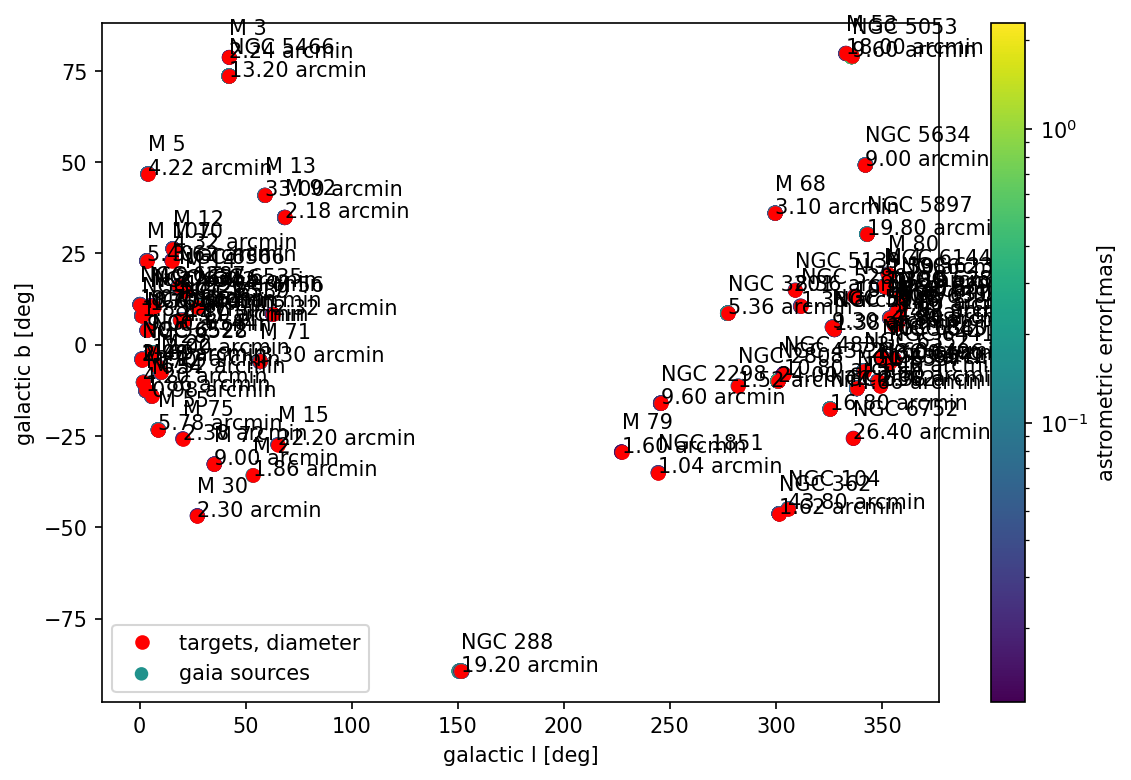

In [8]:
style = {'description_width': 'initial'}
layout = {'width': '100%'}
distance_slider = widgets.FloatSlider(value=30, min=0, max=60, continuous_update=False,
                               description = 'cutoff distance in arcseconds', style=style, layout=layout)
quality_slider = widgets.FloatSlider(value=0.5, min=0, max=1, continuous_update=False,
                              description = 'cutoff source fidelity', style=style, layout=layout)
error_slider = widgets.FloatSlider(value=4, min=0, max=5, continuous_update=False, step=0.005,
                              description = 'max astrometric error [mas]', style=style, layout=layout)
target_dropdown = widgets.Dropdown(options=['all']+list(np.unique(combined_table['target_name_id'])), description='Target', layout={'width': '40%'})

def neigbour_plot(table, cutoff_distance, source_quality, max_error, target):
    plt.clf()
    if target != 'all':
        table = table[table['target_name_id']==target]
    table = table[(table['target_dist']<cutoff_distance*u.arcsec)&
                  (table['good']>source_quality)&
                  (table['ra_error']<max_error*u.mas)&
                  (table['dec_error']<max_error*u.mas)]
    if len(table) == 0:
        return
    target_coordinates=table['target_coordinates'].galactic
    source_coordinates=table['source_coordinates'].galactic
    
    #xerr, yerr = table['ra_error'].to(u.deg).value, table['dec_error'].to(u.deg).value    
    #plt.errorbar(source_coordinates.l.value, source_coordinates.b.value, xerr, yerr, '.')
    
    #plt.scatter(source_coordinates.l, source_coordinates.b, c=table['good'], label='gaia sources')
    combined_error = np.sqrt(table['ra_error']**2+table['dec_error']**2)
    # Bigger marker -> better chance that source is good
    plt.scatter(source_coordinates.l, source_coordinates.b, c=combined_error, s=table['good']*40 ,label='gaia sources', norm=LogNorm())

    for i,group in enumerate(table.group_by('target_name_id').groups):
        entry = group[0]
        coords = entry['target_coordinates'].galactic
        x,y,name = coords.l.value, coords.b.value, entry['target_name_id']
        a = (entry['GALDIM_MAJAXIS']*u.arcmin)
        plt.plot(coords.l, coords.b, 'ro')
        plt.text(x,y,f'{name}\n{a:.2f}')

    plt.plot([],[], 'ro', label='targets, diameter')

    cbar=plt.colorbar()
    cbar.set_label('astrometric error[mas]')
    #cbar.set_label('p(solution good) [0-1]')

    plt.xlabel('galactic l [deg]')
    plt.ylabel('galactic b [deg]')
    #plt.plot(target_coord.dec, source_coordinates.dec)
    plt.legend()

plt.figure()
widgets.interact(lambda a,b,c,d: neigbour_plot(combined_table,a,b,c,d), a=distance_slider, b=quality_slider, c=error_slider, d=target_dropdown)
pass

## Gaia Source density

With the MICADO FOV of $1 \mathrm{as}^2$ [citation_needed]  it is easy to estimate the expected number of gaia sources in a frame from the density, i.e. number of sources per solid angle. For some sources the source density seems to be lower in the central region, therefore it is calculated for two radii of $60 \mathrm{as}$ and $30 \mathrm{as}$:

In [9]:
out_tables = []
for radius in [10,20,30,40,50,60]*u.arcsec:
    current = filtered_table['target_name_id','target_dist']
    count_within = current.group_by('target_name_id').groups.aggregate(lambda col: np.sum(col<=radius))
    colname = f'within {radius}'
    count_within.rename_column('target_dist', colname)
    count_within[colname].unit=None
    out_tables.append(count_within)
# take two columns from first table, only second column from other tables to not have duplicate name columns    
good_within = astropy.table.hstack([out_tables[0]]+[out_table[out_table.colnames[1:]] for out_table in out_tables[1:]])

good_within = astropy.table.join(good_within,
                                 astropy.table.unique(filtered_table['target_name_id','target_coordinates','GALDIM_MAJAXIS']),
                                 keys='target_name_id', join_type='left')
good_within['density_60'] = good_within['within 60.0 arcsec']*u.count/(np.pi*(1*u.arcmin)**2)
good_within['density_30'] = good_within['within 30.0 arcsec']*u.count/(np.pi*(0.5*u.arcmin)**2)
good_within.sort('density_30')

print(np.min(good_within['density_60']), np.max(good_within['density_60']))

2.5464790894703255 212.63100397077218


The source density in the $30\mathrm{as}$ cone spans a wide range from no stars for NGC 6440 and NGC 6356to $196 \frac{\mathrm{stars}}{\mathrm{arcmin}^2}$ for M4. If MICADO is observing the center of the object, those would be included in the image irregardles of the rotation of the FOV.

Only for 4 clusters there are less than 5 suitable guide source in the cone:

In [10]:
problem_table = good_within[good_within['density_30']<5]['target_name_id', 'density_30']
problem_table

target_name_id,density_30
,ct / arcmin2
str8,float64
NGC 6440,0.0
NGC 6388,0.0
NGC 6356,1.2732395447351628
NGC 6441,1.2732395447351628


sources, there are fewer than ten expected sources in the FOV.
### Angular size
The angular size of the sampled clusters is typically in the $5 \mathrm{arcmin}$ range, with the smallest one still having a major axis of $0.98 \mathrm{arcmin}$. So for nearly all of the objects considered here, an analysis of the cluster similar to [4] would have to use multiple exposures to cover all sources within the object. as the source density tends to slightly increases away from the center of the clusters  [link], analyzing the central region checks the worst case.

In [11]:
print(
'Sizes: ',    
'min: ', np.min(good_within['GALDIM_MAJAXIS']),
'max: ', np.max(good_within['GALDIM_MAJAXIS']),
'median: ', np.median(good_within['GALDIM_MAJAXIS']),
'std: ', np.std(good_within['GALDIM_MAJAXIS'])
)

Sizes:  min:  0.98 max:  43.8 median:  4.27 std:  8.155344


## Correlation of density with position on sky
There's no clear trend between position relative to the galaxy apparent from the following plots

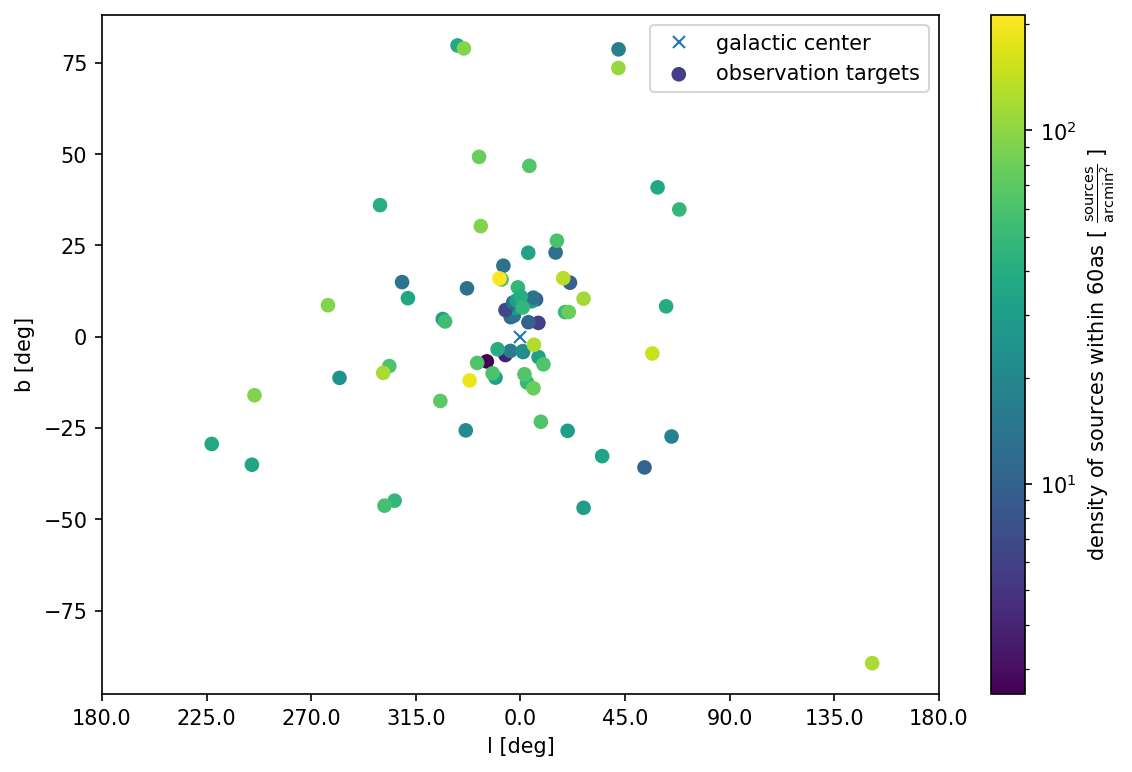

In [12]:
plt.figure()
l = good_within['target_coordinates'].galactic.l
b = good_within['target_coordinates'].galactic.b

plt.plot(180,0,'x', label='galactic center')
plt.scatter((l.value+180)%360,b,c=good_within['density_60'], norm=LogNorm() , label='observation targets')
plt.xlim(0,360)
xs=np.linspace(0,360,9)
xlab=(xs+180)%360
plt.xticks(xs, xlab)

plt.xlabel('l [deg]')
plt.ylabel('b [deg]')
cbar = plt.colorbar()
cbar.set_label(r'density of sources within $60\mathrm{as}$ [ $\frac{\mathrm{sources}}{\mathrm{arcmin}^2}$ ]')
plt.legend()
pass

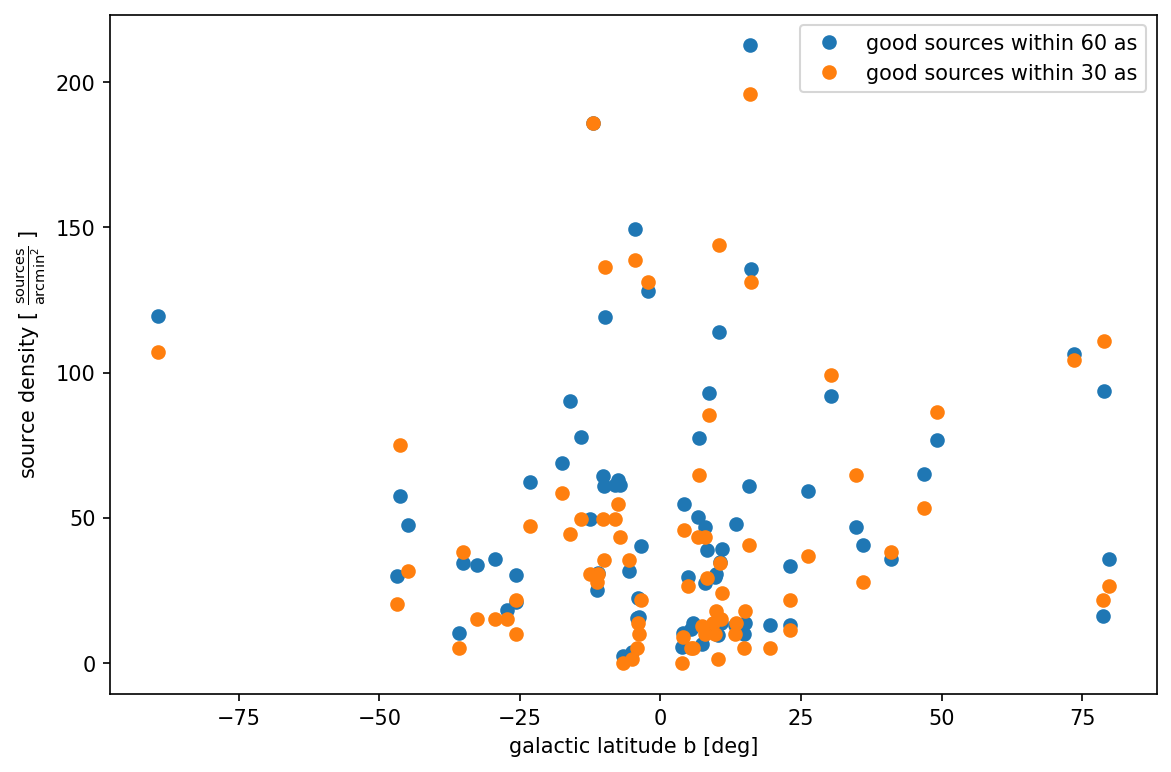

In [13]:
plt.figure()
center = SkyCoord(0,0,frame='galactic',unit=u.deg)
plt.plot(good_within['target_coordinates'].galactic.b, good_within['density_60'], 'o', label='good sources within 60 as')
plt.plot(good_within['target_coordinates'].galactic.b, good_within['density_30'], 'o', label='good sources within 30 as')
plt.ylabel(r'source density [ $\frac{\mathrm{sources}}{\mathrm{arcmin}^2}$ ]')
plt.xlabel('galactic latitude b [deg]')
plt.legend()
pass

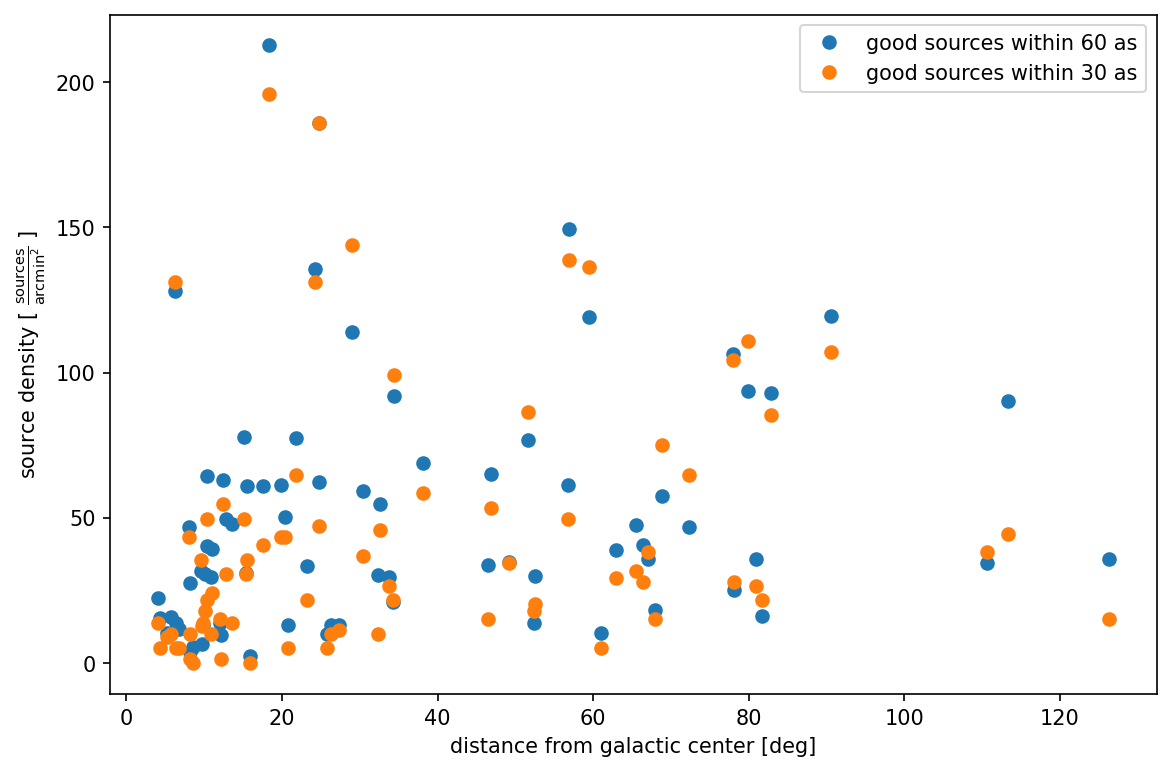

In [14]:
plt.figure()
center = SkyCoord(0,0,frame='galactic',unit=u.deg)
plt.plot(center.separation(good_within['target_coordinates']), good_within['density_60'], 'o', label='good sources within 60 as')
plt.plot(center.separation(good_within['target_coordinates']), good_within['density_30'], 'o', label='good sources within 30 as')
plt.ylabel(r'source density [ $\frac{\mathrm{sources}}{\mathrm{arcmin}^2}$ ]')
plt.xlabel('distance from galactic center [deg]')
plt.legend()
pass

## Density vs Radius

There is a very slight trend towards an increase in source density further from the object center, especially for objects with a low density of good sources

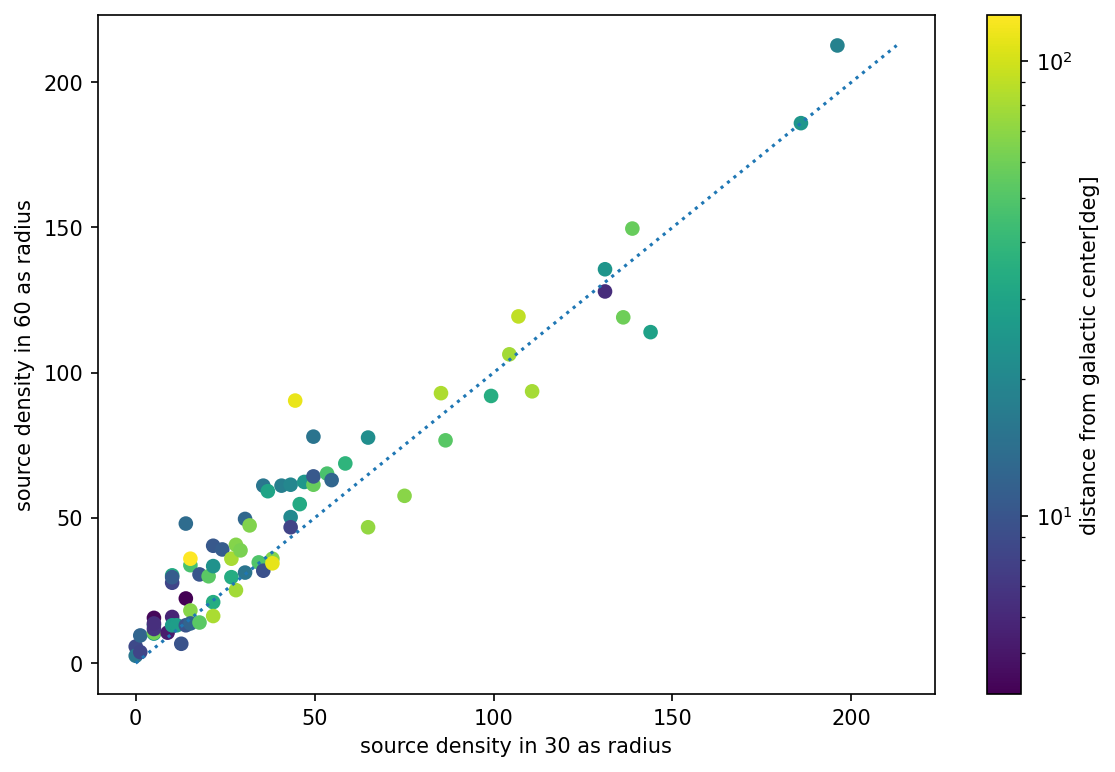

In [15]:
plt.figure()
plt.scatter(good_within['density_30'], good_within['density_60'], c=center.separation(good_within['target_coordinates']).value, norm=LogNorm())

max_point = np.max((good_within['density_30'],good_within['density_60']))
plt.plot([0,max_point],[0,max_point], linestyle='dotted')
cbar=plt.colorbar()
cbar.set_label('distance from galactic center[deg]')
plt.xlabel('source density in 30 as radius')
plt.ylabel('source density in 60 as radius')
pass

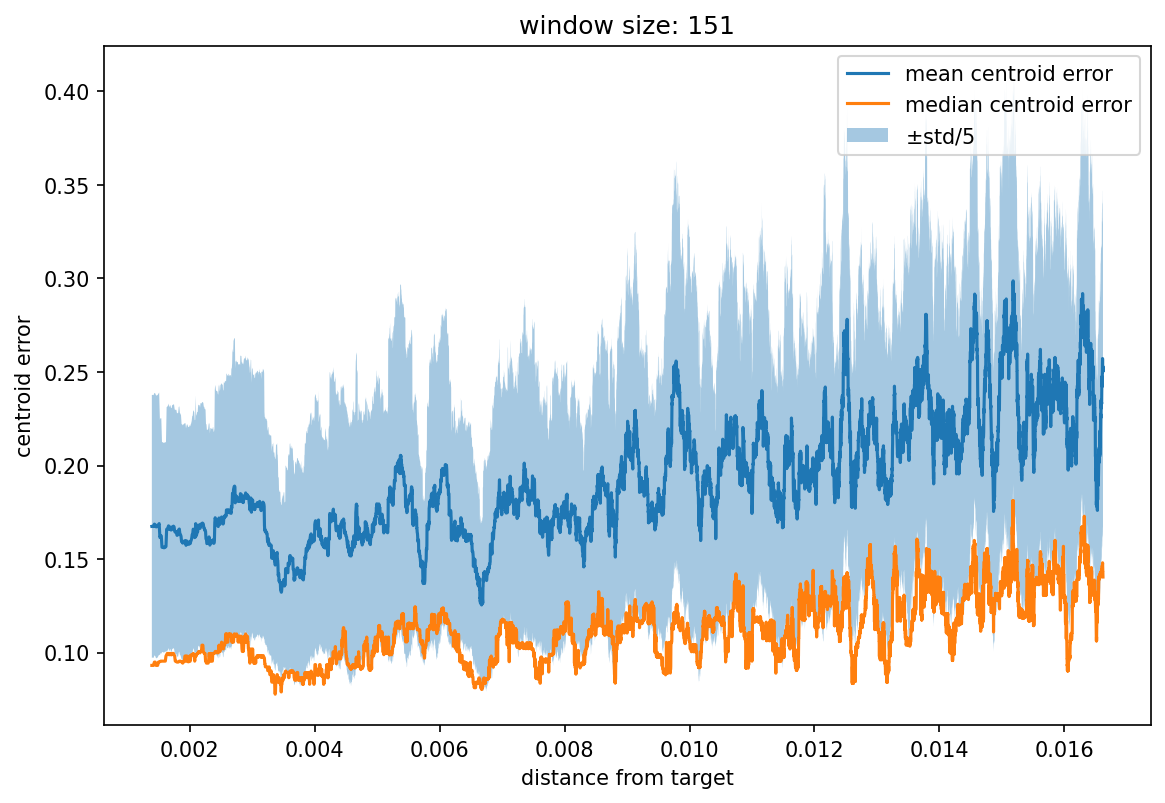

In [16]:
from numpy.lib.stride_tricks import sliding_window_view
window = 151

filtered_table.sort('target_dist')
dists = sliding_window_view(filtered_table['target_dist'], window)
errors = sliding_window_view(filtered_table['combined_error'], window)

xs = np.mean(dists, axis=1)
ys = np.mean(errors, axis=1)
ys_med = np.median(errors, axis=1)
yerr = np.std(errors, axis=1)

plt.figure()
plt.plot(xs, ys, label='mean centroid error')
plt.fill_between(xs, ys+yerr/3, ys-yerr/3, alpha=0.4, label=r'$\pm \mathrm{std}/{5}$ ')
plt.plot(xs, ys_med, label= 'median centroid error')

plt.xlabel('distance from target')
plt.ylabel('centroid error')
plt.title(f'window size: {window}')
plt.legend()
pass

There is a slight trend towards higher centroid errors further away from the target. Sources with a higher centroid error display a higher fidelity at all radii, as expected

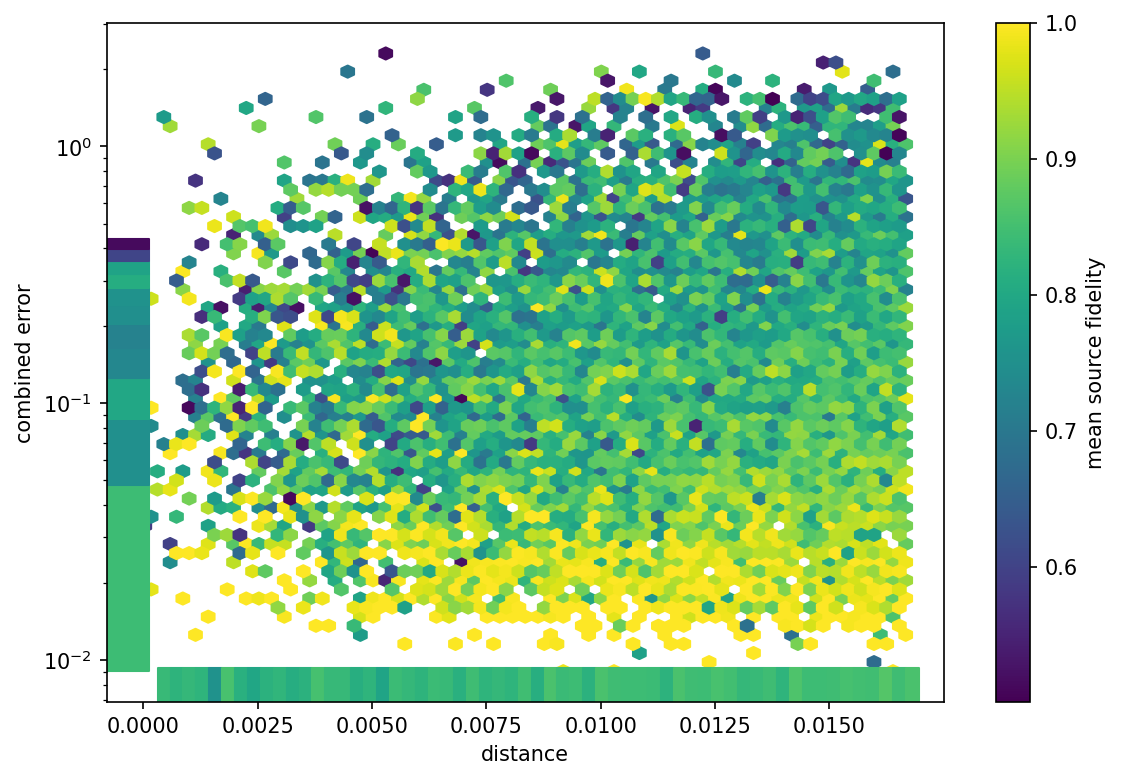

In [17]:
plt.figure()

plt.hexbin(filtered_table['target_dist'], filtered_table['combined_error'], C=filtered_table['good'],
           reduce_C_function=np.mean,
           yscale='log', marginals=True, gridsize=60)

plt.xlabel('distance')
plt.ylabel('combined error')
cbar=plt.colorbar()
cbar.set_label('mean source fidelity')

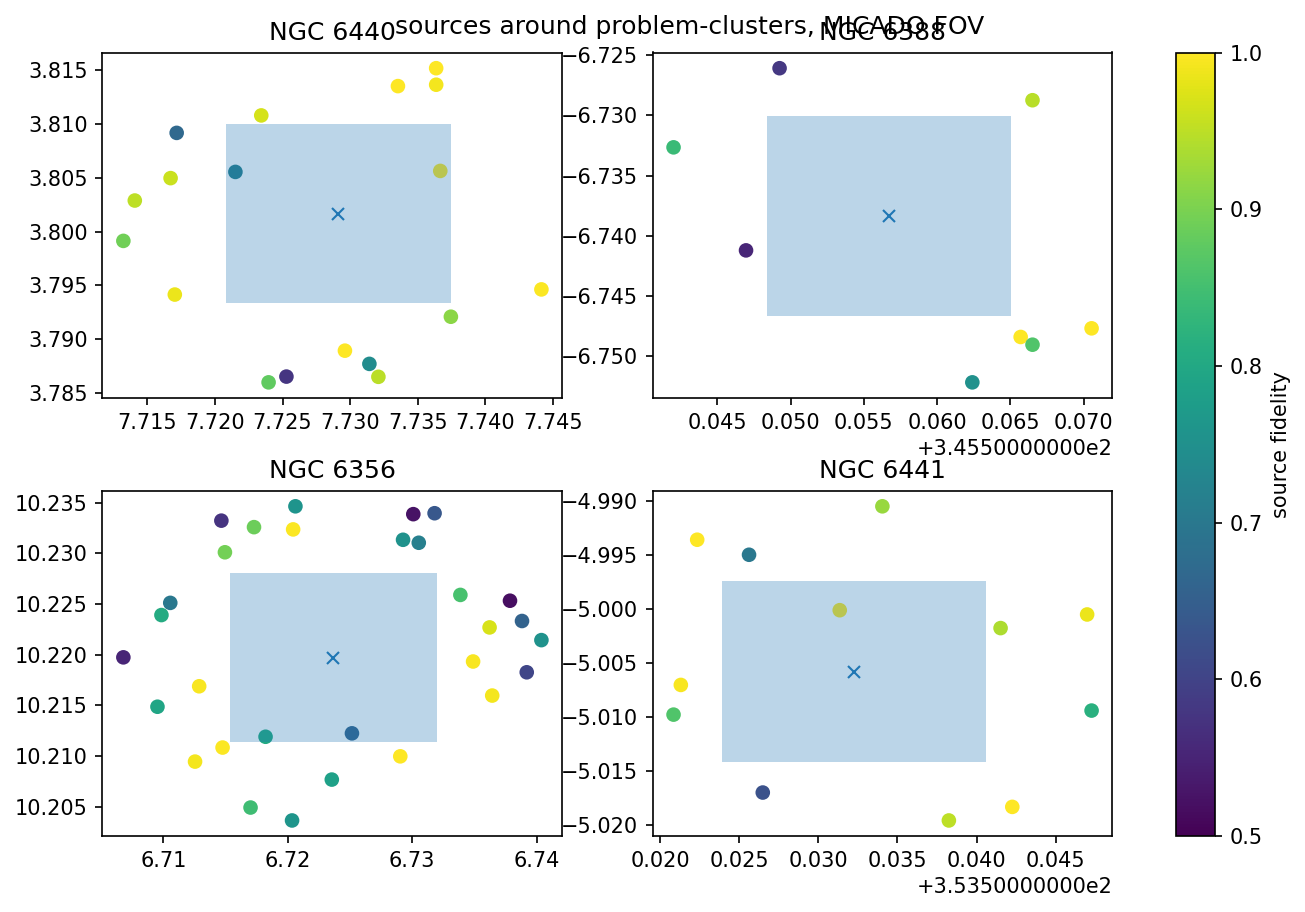

In [18]:
fig, axs = plt.subplots(int(np.ceil(len(problem_table)/2)), 2)

width = height = 1*u.arcmin

for i,name in enumerate(problem_table['target_name_id']):
    sources = filtered_table[filtered_table['target_name_id']  == name]
    target_coordinates = sources['target_coordinates'][0].galactic
    source_coordinates = sources['source_coordinates'].galactic
    
    ax = axs.flatten()[i]
    ax.plot(target_coordinates.l, target_coordinates.b, 'x', label='target')
    sc=ax.scatter(source_coordinates.l, source_coordinates.b, c=sources['good'], vmin=0.5, vmax=1)
    
    x,y=(target_coordinates.l-width/2).value, (target_coordinates.b-height/2).value
    
    rect = plt.Rectangle((x,y), width.to(u.deg).value, height.to(u.deg).value, alpha=0.3)
    ax.add_patch(rect)
    ax.set_title(sources['target_name_id'][0])

plt.suptitle('sources around problem-clusters, MICADO FOV')
fig.tight_layout(pad=0, h_pad=0.01,w_pad=0.05)
cbar=plt.colorbar(sc, ax=axs.flatten().tolist())
cbar.set_label('source fidelity')


pass

# Conclusion

For nearly all analyzed targets GAIA preliminary DR3 contains ample reference stars for astrometric calibration. Even for the problem-child clusters except maybe NGC 6388 it should be possible to include at least two reference sources by rotating and shifting the frame slightly around the observation center

With the code contained in this notebook and connected files, it should be straightforward to adapt this overview to another set of observation targets or perform more detailed analysis for certain objects.

 # Literature
 - [1] Rybitzky https://ui.adsabs.harvard.edu/abs/2021arXiv210111641R/abstract
 
 - [2] Riechert 2018
 
 - [3] Collaboration, Gaia, A. Helmi, F. van Leeuwen, P. J. McMillan, D. Massari, T. Antoja, A. C. Robin, et al. “Gaia Data Release 2. Kinematics of Globular Clusters and Dwarf Galaxies around the Milky Way.” Astronomy &amp; Astrophysics, Volume 616, Id.A12, <NUMPAGES>47</NUMPAGES> Pp. 616 (August 2018): A12. https://doi.org/10.1051/0004-6361/201832698.

- [4] Häberle, Maximilian. “An Astrometric Study of the Core of the Globular Cluster NGC 6441 Using the Hubble Space Telescope and NACO @ VLT,” 2020.


# Compost

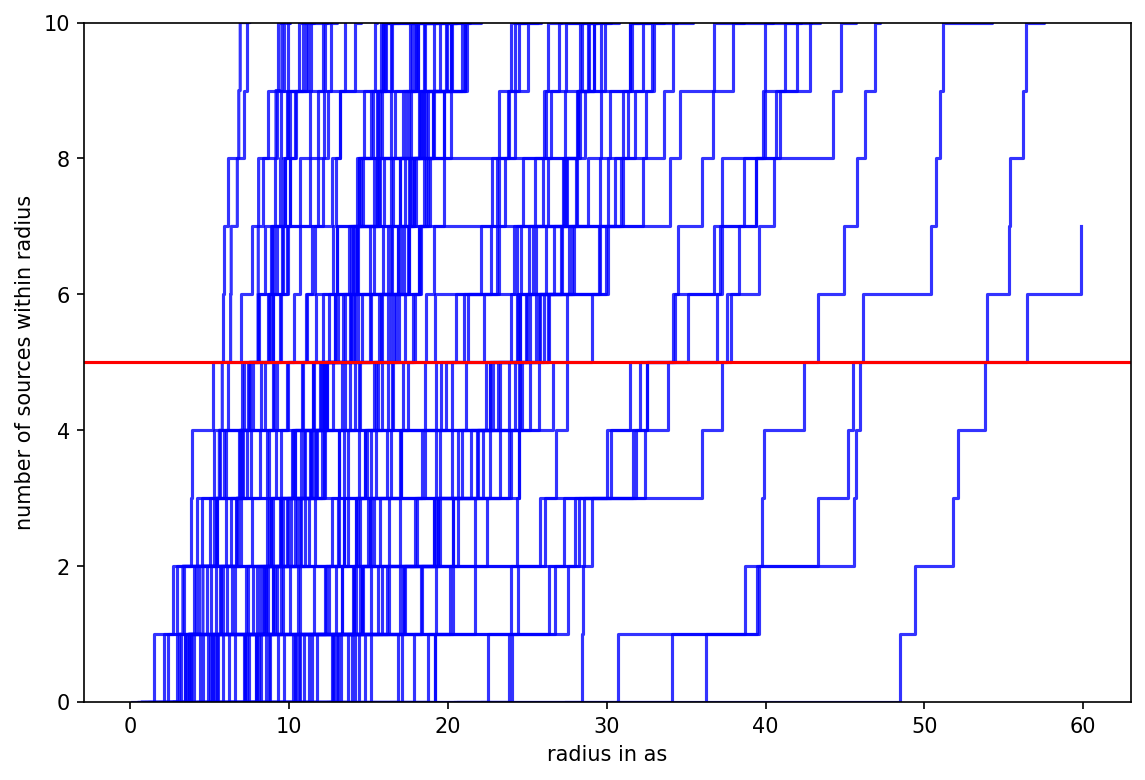

In [38]:
plt.figure()

current = filtered_table['target_name_id','target_dist']
groups=current.group_by('target_name_id').groups
for name, group in zip(groups.keys, groups):
    group.sort('target_dist')
    xs = group['target_dist'].to(u.arcsecond)
    ys = range(0,len(group))
    plt.step(xs,ys, alpha=0.8, where='post', color='blue')

plt.axhline(5, color='red')    
plt.xlabel('radius in as')
plt.ylabel('number of sources within radius')
plt.ylim(0,10)
pass